In [36]:
import sys
from typing import List, Tuple, Any, Set

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


sys.path.append('../..')
from utils import set_seed, plot_graph, plot_shortest_path

# Set random seed for reproducibility
set_seed(42)

In [37]:
class AntColony(object):
    def __init__(self, distances_array: np.ndarray, n_ants: int, n_best: int, n_iterations: int, decay: float, alpha: float = 1, beta: float = 1) -> None:
        """
        Initialize the Ant Colony class for solving optimization problems like TSP.

        Args:
            distances_array (np.ndarray): 2D array representing distances between points.
            n_ants (int): Number of ants.
            n_best (int): Number of best paths selected per generation.
            n_iterations (int): Number of iterations.
            decay (float): Evaporation rate for pheromone.
            alpha (float, optional): Importance of pheromone. Defaults to 1.
            beta (float, optional): Importance of visibility. Defaults to 1.
        """
        self.distances: np.ndarray = distances_array
        self.pheromone: np.ndarray = np.ones(self.distances.shape) / len(distances_array)
        self.all_indexes: range = range(len(distances_array))
        self.n_ants: int = n_ants
        self.n_best: int = n_best
        self.n_iterations: int = n_iterations
        self.decay: float = decay
        self.alpha: float = alpha
        self.beta: float = beta
        self.iterations_explored: int = 0

    def run(self) -> Tuple[Any, List[float]]:
        """ Run the Ant Colony algorithm """
        shortest_path_found = None
        all_time_shortest_path = ("placeholder", np.inf)
        cost_list: List[float] = []  # List to store the cost of shortest path of each iteration
        for i in range(self.n_iterations):
            self.iterations_explored += 1
            all_paths = self.gen_all_paths()
            self.spread_pheromone(all_paths, self.n_best, shortest_path_found=shortest_path_found)
            shortest_path_found = min(all_paths, key=lambda x: x[1])
            cost_list.append(shortest_path_found[1])  # Append the cost of the current shortest path
            if shortest_path_found[1] < all_time_shortest_path[1]:
                all_time_shortest_path = shortest_path_found
            self.pheromone = self.pheromone * self.decay  # Apply decay to pheromone
        return all_time_shortest_path, cost_list

    def spread_pheromone(self, all_paths: List[Tuple[Any, float]], n_best: int, shortest_path_found: Any) -> None:
        """ Spread pheromone """
        sorted_paths = sorted(all_paths, key=lambda x: x[1])
        for path, dist in sorted_paths[:n_best]:
            for move in path:
                self.pheromone[move] += 1.0 / self.distances[move]
        # Extra pheromone for the current iteration's shortest path
        if shortest_path_found is not None:
            for move in shortest_path_found[0]:
                self.pheromone[move] += 1.0 / self.distances[move]

    def gen_path_dist(self, path: List[Tuple[int, int]]) -> float:
        """ Calculate path length """
        total_dist = 0
        for ele in path:
            total_dist += self.distances[ele]
        return total_dist

    def gen_all_paths(self) -> List[Tuple[Any, float]]:
        """ Generate all ants' paths """
        all_paths: List[Tuple[Any, float]] = []
        for i in range(self.n_ants):
            path = self.gen_path(0)
            all_paths.append((path, self.gen_path_dist(path)))
        return all_paths

    def gen_path(self, start: int) -> List[Tuple[int, int]]:
        """ Generate a path """
        path: List[Tuple[int, int]] = []
        visited: Set[int] = set()
        visited.add(start)
        prev: int = start
        for i in range(len(self.distances) - 1):
            move = self.pick_move(self.pheromone[prev], self.distances[prev], visited)
            path.append((prev, move))
            prev = move
            visited.add(move)
        path.append((prev, start))  # return to start
        return path

    def pick_move(self, pheromone: np.ndarray, dist: np.ndarray, visited: Set[int]) -> int:
        """ Choose next move """
        pheromone = np.copy(pheromone)  # Copy pheromone array to avoid modifying original
        pheromone[list(visited)] = 0  # Set pheromone of visited points to 0
        row = pheromone ** self.alpha * ((1.0 / (dist + 1e-10)) ** self.beta)  # Avoid division by 0
        norm_row = row / row.sum()  # Normalize probability distribution
        move = np_choice(self.all_indexes, 1, p=norm_row)[0]  # Choose next move based on probability distribution
        return move


# Helper function to simulate the probability choice in numpy
def np_choice(a: List[int], size: int, p: np.ndarray) -> np.ndarray:
    """Simulate numpy's choice function for probability-based selection.

    Args:
        a (List[int]): List of choices.
        size (int): Number of samples to draw.
        p (np.ndarray): Probabilities for each choice.

    Returns:
        np.ndarray: Selected choices.
    """
    return np.random.choice(a, size=size, replace=False, p=p)


def solve_tsp(distances_array: np.ndarray, n_ants: int = 10, n_best: int = 5, 
              n_iterations: int = 100, decay: float = 0.95, alpha: float = 5, 
              beta: float = 1) -> Tuple[List[Tuple[int, int]], float, List[float], int]:
    """
    Solves the Traveling Salesman Problem using Ant Colony Optimization.

    Args:
        distances_array (np.ndarray): 2D array representing distances between nodes.
        n_ants (int, optional): Number of ants. Defaults to 10.
        n_best (int, optional): Number of best paths selected per generation. Defaults to 5.
        n_iterations (int, optional): Number of iterations. Defaults to 100.
        decay (float, optional): Evaporation rate for pheromone. Defaults to 0.95.
        alpha (float, optional): Importance of pheromone. Defaults to 5.
        beta (float, optional): Importance of visibility. Defaults to 1.

    Returns:
        Tuple[List[Tuple[int, int]], float, List[float], int]: Best path, best cost, cost history, and iterations explored.
    """
    solver = AntColony(distances_array, n_ants, n_best, n_iterations, decay, alpha, beta)
    (best_path, best_cost), cost_history = solver.run()
    return best_path, best_cost, cost_history, solver.iterations_explored

In [38]:
# Load the fixed distance matrix from CSV using pandas
distances_df = pd.read_csv('../../data/distances.csv', header=None)
distances = distances_df.values
distances

array([[ 0, 47, 42, 17, 36, 11, 16, 48, 21, 43],
       [49,  0, 49,  9, 18, 13,  4, 30, 33, 32],
       [ 4, 21,  0, 14, 32,  1, 21, 22,  4, 46],
       [31, 44, 25,  0, 38,  2, 42, 13,  4, 46],
       [24, 48, 20, 40,  0, 43, 26, 37, 14, 39],
       [39, 12, 12, 33, 47,  0, 15,  8, 49, 20],
       [40, 12, 17, 49, 38,  8,  0,  7, 18, 32],
       [22, 18, 21, 36, 34, 41,  6,  0, 46, 48],
       [41, 29, 35, 12,  4,  4,  7, 49,  0, 16],
       [ 1, 27, 23, 23, 46, 33, 15, 21, 47,  0]])

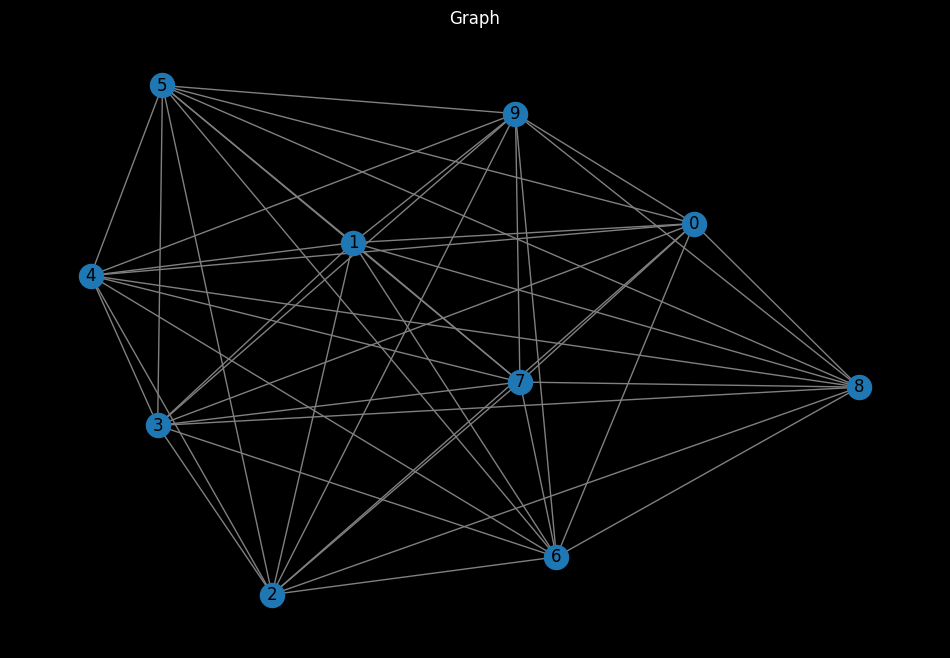

In [39]:
# Plot the graph
plot_graph(distances)

In [40]:
# Solve the TSP using Ant Colony Optimization
best_path, best_cost, cost_history, iterations_explored = solve_tsp(distances, n_ants=10, n_best=5, n_iterations=100, decay=0.95, alpha=5, beta=1)
print(f"Best path: {best_path}")
print(f"Best cost: {best_cost}")
print(f"Iterations explored: {iterations_explored}")

Best path: [(0, np.int64(6)), (np.int64(6), np.int64(7)), (np.int64(7), np.int64(1)), (np.int64(1), np.int64(3)), (np.int64(3), np.int64(5)), (np.int64(5), np.int64(2)), (np.int64(2), np.int64(8)), (np.int64(8), np.int64(4)), (np.int64(4), np.int64(9)), (np.int64(9), 0)]
Best cost: 112
Iterations explored: 100


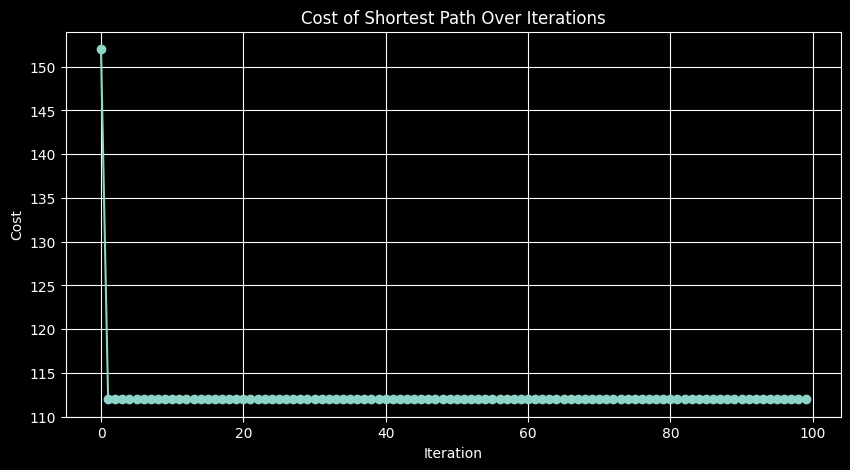

In [41]:
# Plot the costs
plt.figure(figsize=(10, 5))
plt.plot(cost_history, marker='o')
plt.title('Cost of Shortest Path Over Iterations')
plt.xlabel('Iteration')
plt.ylabel('Cost')
plt.grid(True)
plt.show()

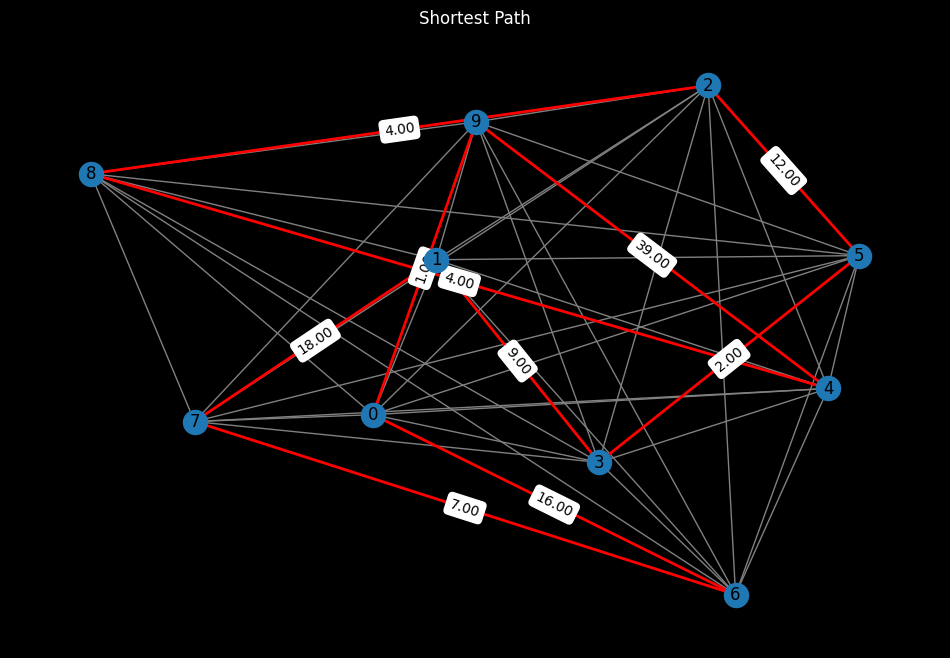

In [42]:
# Plot the shortest path
plot_shortest_path(distances, best_path)